# Objects elongation

This notebook has the obejective to calculate the elongation of the objects in the images, given the objects' contours.
To this, we use eigenvalues and eigenvectors of the covariance matrix of the objects' contours.
The enlongation is given by the ratio between the largest and the smallest eigenvalues.


# Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import cv2
from PIL import Image
import os
import pandas as pd
import plotly.express as px

# Defining functions

## Function to calculate the elongation

In [4]:
# Function to calculate the elongation
def elongation_cv2(img):
    """Function to calculate the elongation of an object in an image
    Parameters
    ----------
    img : array
        Image
    Returns
    -------
    elong : float
        Elongation of the object in the image

    """
    # Converting the image to np.array
    img = np.array(img)
    # Calculating the contours of the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Calculating the covariance matrix of the contours
    #cov = np.cov(contours[0][:,0,:].T)

    coords = np.vstack(contours).squeeze()
    cov = np.cov(coords.T)
    # Calculate eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)

    # Calculating the elongation
    elong = 1 - np.min(eigvals)/np.max(eigvals)
    return elong, eigvals, contours, cov

In [5]:
# Function to calculate the elongation
def elongation_numpy(img):
    """Function to calculate the elongation of an object in an image
    Parameters
    ----------
    img : array
        Image
    Returns
    -------
    elong : float
        Elongation of the object in the image

    """
    # Converting the image to np.array
    img = np.array(img)
    # Calculating the contours of the image
    contours_coord = np.array(np.nonzero(img))
    # Calculating the covariance matrix of the contours
    cov = np.cov(contours_coord)
    # Calculating the eigenvalues and eigenvectors of the covariance matrix
    eigvals = np.linalg.eigvalsh(cov)
    # Calculating the elongation
    elong = 1 - np.min(eigvals)/np.max(eigvals)
    return elong, eigvals, contours_coord, cov

## Function to plot the elongation

In [6]:
# Function to plot the elongation
def plot_elongation(elong):
    # Plotting the elongation
    plt.figure(figsize=(10,5))
    plt.plot(elong)
    plt.title('Elongation')
    plt.xlabel('Image')
    plt.ylabel('Elongation')
    plt.show()

## Function to load the images

In [7]:
def data_load(path, resize=True, size=(32,32)):
    """Function to load the images from a given path
    Parameters
    ----------
    path : str
        Path to the images
    Returns
    -------
    imgs : list
        List of images

    """
    imgs = []
    for filename in os.listdir(path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(path,filename)
            img = Image.open(file_path).convert('L')
            if resize:
                img = img.resize(size)
            if img is not None:
                imgs.append(img)
    return imgs

In [8]:
def calculate_elongation_multiple_folders(folder_path, save_file_name='elongation', file_type='json', method='numpy'):
    """
    Calculate elongation for all images in folder and subfolders and save results to file
    Parameters
    ----------
    folder_path : str
        Path to folder containing images
    save_file_name : str
        Name of file to save results to (without file extension)
    file_type : str
        Type of file to save results to (json or csv)

    Returns
    -------
    None
    """

    # Recursively search for images in all subfolders of the root folder
    for root, dirs, files in os.walk(folder_path):
        results = []
        for filename in files:
            if filename.endswith('.png') or filename.endswith('.jpg'):
                file_path = os.path.join(root, filename)
                if method == 'numpy':
                    result = calculate_elongation_numpy(file_path)
                elif method == 'cv2':
                    result = calculate_elongation_cv2(file_path)
                results.append(result)

        # Save results to file
        if file_type == 'json':
            output_path = os.path.join(root, f'{save_file_name}.{file_type}')
            with open(output_path, 'w') as f:
                json.dump(results, f)
        elif file_type == 'csv':
            output_path = os.path.join(root, f'{save_file_name}.{file_type}')
            if len(results) > 0:
                with open(output_path, 'w', newline='') as f:
                    writer = csv.DictWriter(f, fieldnames=results[0].keys())
                    writer.writeheader()
                    writer.writerows(results)
            else:
                print(f'No images found in folder {root}')
        else:
            raise ValueError('Invalid file type specified')

    # Return None
    return None

def calculate_elongation_one_folder(folder_path, save_file_name='elongation', file_type='json',  method='numpy'):
    """
    Calculate elongation for all images in folder and save results to file
    Parameters
    ----------
    folder_path : str
        Path to folder containing images
    save_file_name : str
        Name of file to save results to (without file extension)
    file_type : str
        Type of file to save results to (json or csv)

    Returns
    -------
    results : dict
    Dictionary containing elongation results for each image in folder (key = image name)
    """

    # Calculate elongation for all images in folder
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(folder_path,filename)
            if method == 'numpy':
                result = calculate_elongation_numpy(file_path)
            elif method == 'cv2':
                result = calculate_elongation_cv2(file_path)
            results.append(result)

    # Save results to file
    if file_type == 'json':
        output_path = os.path.join(folder_path, f'{save_file_name}.{file_type}')
        with open(output_path, 'w') as f:
            json.dump(results, f)
    elif file_type == 'csv':
        output_path = os.path.join(folder_path, f'{save_file_name}.{file_type}')
        with open(output_path, 'w') as f:
            writer = csv.DictWriter(f, fieldnames=results[0].keys())
            writer.writeheader()
            writer.writerows(results)
    else:
        raise ValueError('Invalid file type specified')

    # Return results as dictionary
    return {result['name']: result for result in results}

# Experiment

## Loading the images

In [9]:
# load multiple images into a list
path = '../elongacao_de_objetos/imagens/'
imgs = data_load(path, resize=True, size=(64,64))

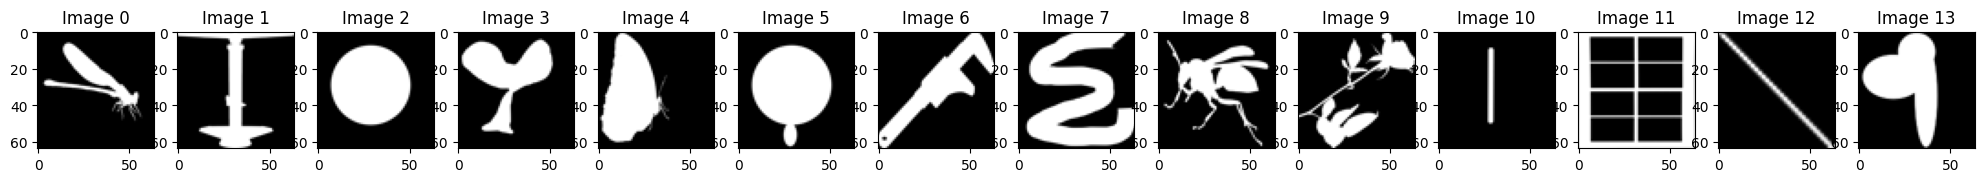

In [10]:
plt.figure(figsize=(25, 12))
for idx, img in enumerate(imgs):
   plt.subplot(1, len(imgs), idx+1)
   plt.imshow(img, cmap='gray')
   plt.title(f"Image {idx}")

In [11]:
print(np.min(imgs[0]))
print(np.max(imgs[0]))

0
255


## Exploring the elongation properties

### Numpy method

In [12]:
elong, eigvals, contours_coord = [], [], []

for img in imgs:
    elong_val, eigvals_val, contours_coord_val, _ = elongation_numpy(img)
    elong.append(elong_val)
    eigvals.append(eigvals_val)
    contours_coord.append(contours_coord_val)


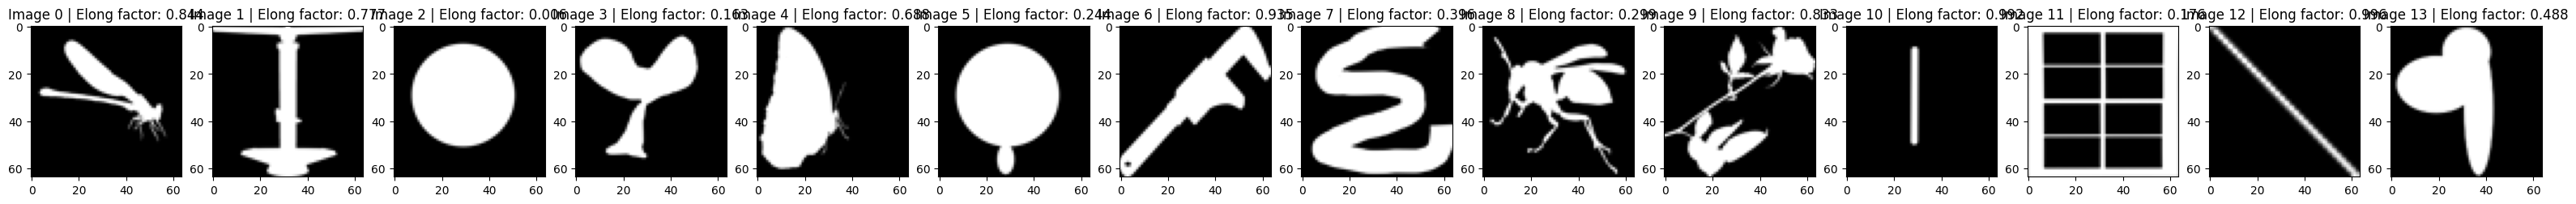

In [13]:
plt.figure(figsize=(40, 30))
for idx, img in enumerate(imgs):
   plt.subplot(1, len(imgs), idx+1)
   plt.imshow(img, cmap='gray')
   plt.title(f"Image {idx} | Elong factor: {round(elong[idx], 3)}")

In [14]:
for idx, img in enumerate(imgs):
    print(f"Eigvals - Image {idx}", eigvals[idx])

Eigvals - Image 0 [ 37.52807835 240.36503013]
Eigvals - Image 1 [116.94178372 523.75023491]
Eigvals - Image 2 [126.19630761 127.00513826]
Eigvals - Image 3 [150.68851303 180.00055315]
Eigvals - Image 4 [ 70.36103243 225.2998924 ]
Eigvals - Image 5 [120.47356502 159.39135422]
Eigvals - Image 6 [ 31.25241649 482.69965279]
Eigvals - Image 7 [217.90568775 360.65436697]
Eigvals - Image 8 [134.04078212 191.28584585]
Eigvals - Image 9 [ 77.65920968 465.89410781]
Eigvals - Image 10 [  1.24556213 151.45339367]
Eigvals - Image 11 [400.82116955 486.56661239]
Eigvals - Image 12 [  2.8228227  644.27477277]
Eigvals - Image 13 [108.02040493 210.96126743]


In [15]:
for idx, img in enumerate(imgs):
    print(f"Elongation factor - Image {idx}", elong[idx])

Elongation factor - Image 0 0.8438704734509127
Elongation factor - Image 1 0.7767222314702948
Elongation factor - Image 2 0.006368487603759965
Elongation factor - Image 3 0.16284416692356896
Elongation factor - Image 4 0.6877005502512501
Elongation factor - Image 5 0.24416499497509714
Elongation factor - Image 6 0.9352549430915862
Elongation factor - Image 7 0.39580466035704576
Elongation factor - Image 8 0.2992645037094438
Elongation factor - Image 9 0.8333114577256844
Elongation factor - Image 10 0.9917759377981897
Elongation factor - Image 11 0.17622549648110586
Elongation factor - Image 12 0.9956186043233871
Elongation factor - Image 13 0.4879609596473753


### CV2 method

In [16]:
elong, eigvals, contours_coord = [], [], []

for img in imgs:
    elong_val, eigvals_val, contours_coord_val, _ = elongation_cv2(img)
    elong.append(elong_val)
    eigvals.append(eigvals_val)
    contours_coord.append(contours_coord_val)

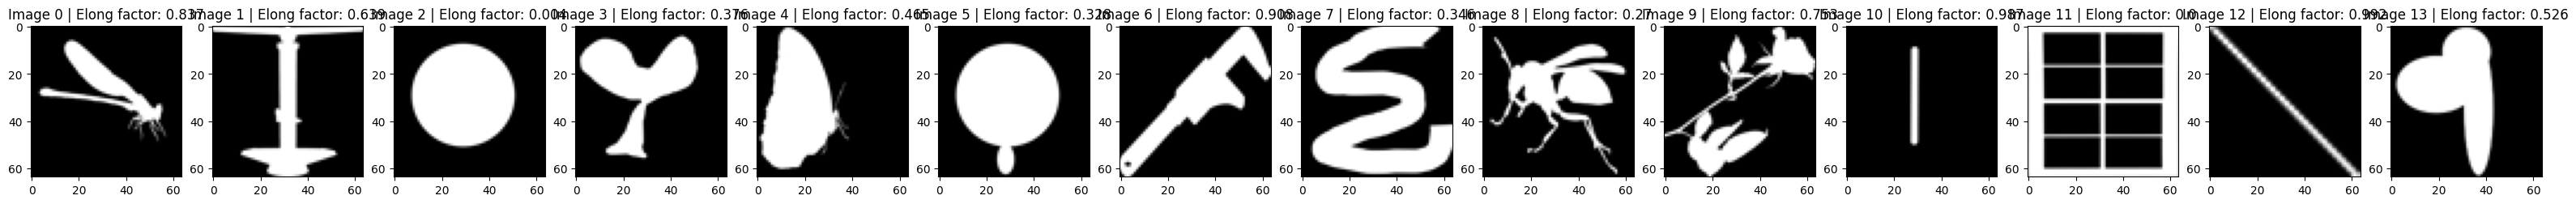

In [17]:
plt.figure(figsize=(40, 30))
for idx, img in enumerate(imgs):
   plt.subplot(1, len(imgs), idx+1)
   plt.imshow(img, cmap='gray')
   plt.title(f"Image {idx} | Elong factor: {round(elong[idx], 3)}")

In [18]:
for idx, img in enumerate(imgs):
    print(f"Eigvals - Image {idx}", eigvals[idx])

Eigvals - Image 0 [314.33145171  51.14838506]
Eigvals - Image 1 [201.23959234 557.09655036]
Eigvals - Image 2 [245.71059303 244.68220791]
Eigvals - Image 3 [178.82387357 286.6724334 ]
Eigvals - Image 4 [165.95190716 310.47026817]
Eigvals - Image 5 [216.07911868 321.70476904]
Eigvals - Image 6 [640.16580879  59.01280698]
Eigvals - Image 7 [260.53932163 398.25872292]
Eigvals - Image 8 [304.47489381 222.11924795]
Eigvals - Image 9 [102.34023959 414.09753212]
Eigvals - Image 10 [  2.18390805 162.13740857]
Eigvals - Image 11 [664.21912351 664.21912351]
Eigvals - Image 12 [  5.74187333 688.12075601]
Eigvals - Image 13 [166.17206757 350.35384489]


In [19]:
for idx, img in enumerate(imgs):
    print(f"Elongation factor - Image {idx}", elong[idx])

Elongation factor - Image 0 0.8372788189743564
Elongation factor - Image 1 0.6387707082215486
Elongation factor - Image 2 0.004185351183059183
Elongation factor - Image 3 0.37620833837480794
Elongation factor - Image 4 0.46548212768752595
Elongation factor - Image 5 0.328331005718567
Elongation factor - Image 6 0.9078163716879832
Elongation factor - Image 7 0.34580385403448677
Elongation factor - Image 8 0.27048419275237334
Elongation factor - Image 9 0.7528595761705021
Elongation factor - Image 10 0.9865305109705443
Elongation factor - Image 11 0.0
Elongation factor - Image 12 0.9916557184448415
Elongation factor - Image 13 0.525702172281735


# Elongation calculation

### Elongation calculation functions

In [20]:
import re

nome_do_arquivo = "xbox_PNG17511.png"
padrao = r'(.*?)_PNG'
resultado = re.search(padrao, nome_do_arquivo)
if resultado:
    parte_desejada = resultado.group(1)
    print(parte_desejada)


xbox


In [21]:
import os
import numpy as np
import cv2
from PIL import Image

# Function to calculate the elongation
def calculate_elongation_numpy(img_path):
    """Function to calculate the elongation of an object in an image
    Parameters
    ----------
    img : array
        Image
    Returns
    -------
    elong : float
        Elongation of the object in the image

    """
    # Load image
    img = Image.open(img_path).convert('L')
    # Converting the image to np.array
    img = np.array(img)
    # Calculating the contours of the image
    contours_coord = np.array(np.nonzero(img))
    # Calculating the covariance matrix of the contours
    cov = np.cov(contours_coord)
    # Calculating the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eig(cov)
    # Calculating the elongation
    elong = 1 - np.min(eigvals)/np.max(eigvals)
    
    image_class =  os.path.basename(img_path).split("_PNG")[0]

    # Return results as dictionary
    results = {
        'full_path' : img_path,
        'dir': os.path.dirname(img_path),
        'file': os.path.basename(img_path),
        'image_class': image_class,
        'elongation': elong,
        'eigenvalues': eigvals.tolist(),
        'eigenvectors': eigvecs.tolist()
    }

    return results


def calculate_elongation_cv2(img_path):
    """Function to calculate the elongation of an object in an image
    Parameters
    ----------
    img : array
        Image
    Returns
    -------
    elong : float
        Elongation of the object in the image

    """
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Calculating the contours of the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Calculating the covariance matrix of the contours
    # cov = np.cov(contours[0][:,0,:].T)
    # Convert a list of contours to a single 2D array of coordinates
    coords = np.vstack(contours).squeeze()
    # Calculate covariance matrix
    cov = np.cov(coords.T)
    # Calculate eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)

    # Calculating the elongation
    elong = 1 - np.min(eigvals)/np.max(eigvals)
    
    image_class =  os.path.basename(img_path).split("_PNG")[0]

    # Return results as dictionary
    results = {
        'full_path' : img_path,
        'dir': os.path.dirname(img_path),
        'file': os.path.basename(img_path),
        'image_class': image_class,
        'elongation': elong,
        'eigenvalues': eigvals.tolist(),
        'eigenvectors': eigvecs.tolist()
    }

    return results




### Elongation calculation over multiple folders

In [22]:
import os
import json
import csv
import numpy as np
import cv2
import multiprocessing
from functools import partial

def worker(file_path, method):
    """
    Calculate elongation for a single image using the specified method.

    Parameters
    ----------
    file_path : str
        Path to the image file.
    method : str
        Method to use for calculating elongation ('numpy' or 'cv2').

    Returns
    -------
    list of dict or None
        A list of dictionaries containing the elongation results for the image, or None if the image could not be processed.
        Each dictionary contains the following keys:
        - 'file_path': the path to the image file
        - 'method': the method used to calculate elongation
        - 'elongation': the elongation value
    """
    if method == 'numpy':
        result = calculate_elongation_numpy(file_path)
    elif method == 'cv2':
        result = calculate_elongation_cv2(file_path)
    return result

def collect_image_paths(dir_path):
    """
    Collect the paths of all image files in the specified directory and its subdirectories.

    Parameters
    ----------
    dir_path : str
        Path to the directory to search for image files.

    Returns
    -------
    list of str
        A list of paths to all image files found in the specified directory and its subdirectories.
        The paths are sorted in lexicographic order.

    Notes
    -----
    This function searches the specified directory and its subdirectories for image files with the extensions '.png' and '.jpg'.
    The function returns a list of paths to all image files found, sorted in lexicographic order.
    """
    image_paths = []
    for root, dirs, files in os.walk(dir_path):
        for filename in files:
            if filename.endswith('.png') or filename.endswith('.jpg'):
                file_path = os.path.join(root, filename)
                image_paths.append(file_path)
    return sorted(image_paths)

def calculate_elongation_multiple_folders_parallel(folder_path, save_file_name='elongation', file_type='json', method='numpy', n_processes=8):
    """
    Calculate elongation for all images in the specified folder and its subfolders using parallel processing,
    and save the results to a file.

    Parameters
    ----------
    folder_path : str
        Path to the folder containing the images.
    save_file_name : str
        Name of the file to save the results to (without file extension).
    file_type : str
        Type of file to save the results to ('json' or 'csv').
    method : str
        Method to use for calculating elongation ('numpy' or 'cv2').
    n_processes : int
        Number of worker processes to use for parallel processing.

    Returns
    -------
    None
        The function saves the results to a file and does not return anything.

    Raises
    ------
    ValueError
        If an invalid file type is specified.

    Notes
    -----
    This function uses the `worker` function to calculate elongation for each image in parallel using a pool of worker processes.
    The function collects the image paths from the specified folder and its subfolders, and saves the elongation results to a file
    in the root folder. The function prints messages to the console to indicate the progress and status of the calculation and saving
    processes.
    """  

    
    # Collect image paths from the specified folder and its subfolders
    image_paths = collect_image_paths(folder_path)

    # Check if there are no image paths
    if not image_paths:
        print(f'No images found in {folder_path} or its subfolders.')
        return

    partial_worker = partial(worker, method=method)

    with multiprocessing.Pool(processes=n_processes) as pool:
        results = pool.map(partial_worker, image_paths)

    all_results = [result for result in results if result is not None]

    # Check if there are valid results
    if not all_results:
        print(f'No valid result found in {folder_path} or its subfolders.')
        return

    # Determine the output path in the root folder
    root_output_directory = folder_path

    if file_type == 'json':
        output_path = os.path.join(root_output_directory, f'{save_file_name}.{file_type}')
        with open(output_path, 'w') as f:
            json.dump(all_results, f)
        print(f'The results were saved in {output_path}')
    elif file_type == 'csv':
        output_path = os.path.join(root_output_directory, f'{save_file_name}.{file_type}')
        with open(output_path, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=all_results[0].keys())
            writer.writeheader()
            writer.writerows(all_results)
        print(f'The results were saved in {output_path}')
    else:
        raise ValueError('Invalid file type specified.')

In [23]:
%%time
path =  '../elongacao_de_objetos'
calculate_elongation_multiple_folders_parallel(
    folder_path=path,
    save_file_name='elongation_numpy',
    file_type='json',
    method='numpy',
    n_processes=12
)

The results were saved in ../elongacao_de_objetos/elongation_numpy.json
CPU times: user 1.01 s, sys: 158 ms, total: 1.17 s
Wall time: 27.8 s


In [23]:
%%time
path =  '../elongacao_de_objetos'
calculate_elongation_multiple_folders_parallel(
    folder_path=path,
    save_file_name='elongation_cv2',
    file_type='json',
    method='cv2',
    n_processes=12
)

The results were saved in ../elongacao_de_objetos/elongation_cv2.json
CPU times: user 330 ms, sys: 92 ms, total: 422 ms
Wall time: 23.9 s


# Analysis

In [35]:
elong_df_numpy = pd.read_json('../elongacao_de_objetos/elongation_numpy.json')
elong_df_cv2 = pd.read_json('../elongacao_de_objetos/elongation_cv2.json')

elong_df_numpy.head(3)

,full_path,dir,file,image_class,elongation,eigenvalues,eigenvectors
0,../elongacao_de_objetos/ThinObject5K_masks/air...,../elongacao_de_objetos/ThinObject5K_masks,air_pump_PNG1.png,air_pump,0.962082,"[5732.196295957659, 217.35206085683953]","[[0.9972868706550451, 0.073613161996123], [-0...."
1,../elongacao_de_objetos/ThinObject5K_masks/air...,../elongacao_de_objetos/ThinObject5K_masks,air_pump_PNG11.png,air_pump,0.978681,"[35.57105243418641, 1668.5327388363337]","[[-0.951049729580378, 0.30903788095489104], [-..."
2,../elongacao_de_objetos/ThinObject5K_masks/air...,../elongacao_de_objetos/ThinObject5K_masks,air_pump_PNG12.png,air_pump,0.962772,"[16211.960538375972, 603.5440337093165]","[[0.999275922936606, -0.038047731064984006], [..."


In [13]:
print(elong_df_numpy.shape[0])

5757


## Stats

In [55]:
pd.DataFrame(elong_df_numpy.groupby('image_class')['elongation'].agg(['mean', 'std']).sort_values(by='mean', ascending=False)).head(20)

,mean,std
image_class,,
billiard,0.999540,NaN
spear,0.999172,0.000688
pencil,0.997944,0.000234
img5.png,0.997360,NaN
flute,0.994723,0.004161
img1.png,0.993872,NaN
pen,0.992514,0.001361
sword,0.991894,0.003695
sewing_needle,0.991770,0.017733


In [59]:
pd.DataFrame(elong_df_numpy.groupby('image_class')['elongation'].agg(['mean', 'std']).sort_values(by='mean', ascending=False)).head(10)

,mean,std
image_class,,
billiard,0.999540,NaN
spear,0.999172,0.000688
pencil,0.997944,0.000234
img5.png,0.997360,NaN
flute,0.994723,0.004161
img1.png,0.993872,NaN
pen,0.992514,0.001361
sword,0.991894,0.003695
sewing_needle,0.991770,0.017733


In [58]:
pd.DataFrame(elong_df_cv2.groupby('image_class')['elongation'].agg(['mean', 'std']).sort_values(by='mean', ascending=False)).head(10)

,mean,std
image_class,,
billiard,0.998958,NaN
spear,0.998209,0.001185
img5.png,0.996114,NaN
pencil,0.994998,0.000615
paddle,0.992041,0.006944
flute,0.988913,0.005948
sewing_needle,0.988014,0.024482
img1.png,0.986020,NaN
sword,0.984961,0.006091


## Distributions

In [33]:
px.histogram(elong_df_numpy, x="elongation", nbins=100, title='Elongation with Numpy', labels={"elongation": "elongation"}, width=700, height=500)

In [60]:
px.histogram(elong_df_cv2, x="elongation", title='Elongation with CV2', nbins=100, labels={"elongation": "elongation"}, width=700, height=500)

In [51]:
elong_df = pd.DataFrame()
elong_df['elongation_numpy'] = elong_df_numpy['elongation']
elong_df['elongation_cv2'] = elong_df_cv2['elongation']
elong_df['full_path'] = elong_df_numpy['full_path']
elong_df['file'] = elong_df_numpy['file']

# px.scatter(elong_df, x="elongation_numpy", y="elongation_cv2", labels={"elongation": "elongation"}, width=700, height=500)

In [61]:
plot_elongation_scatter_with_thumbnails(elong_df)

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
from PIL import Image
import IPython.display as display

def plot_elongation_scatter_with_thumbnails(elong_df):
    """
    Plot a scatter plot of the elongation values and display image thumbnails when the mouse is hovered over the scatter plot points.

    Parameters
    ----------
    elong_df : pandas.DataFrame
        A DataFrame containing the elongation data for each image.
        The DataFrame has the following columns:
        - 'file_path': the path to the image file
        - 'file_name': the name of the image file
        - 'elongation_numpy': the elongation value calculated using NumPy
        - 'elongation_cv2': the elongation value calculated using OpenCV

    Returns
    -------
    None
        The function displays the scatter plot and image thumbnails and does not return anything.
    """
    # Define the size of the thumbnails
    thumb_size = (50, 50)

    # Define the hover template for the scatter plot
    hover_template = '<b>%{text}</b><br>' + \
                      'Elongation (NumPy): %{x:.2f}<br>' + \
                      'Elongation (OpenCV): %{y:.2f}<br>' + \
                      '<img src="%{customdata}" width="' + str(thumb_size[0]) + '" height="' + str(thumb_size[1]) + '">'

    # Create the scatter plot trace
    scatter_trace = go.Scatter(
        x=elong_df['elongation_numpy'],
        y=elong_df['elongation_cv2'],
        text=elong_df['file'],
        customdata=elong_df['full_path'],
        mode='markers',
        marker=dict(
            size=5,
            color='blue'
        ),
        hovertemplate=hover_template
    )

    # Create the figure
    fig = px.scatter(elong_df, x="elongation_numpy", y="elongation_cv2", labels={"elongation_numpy": "Elongation (NumPy)", "elongation_cv2": "Elongation (OpenCV)"}, hover_data=['full_path', 'file'])
    fig.add_trace(scatter_trace)

    # Define the callback function for the hover event
    def hover_callback(trace, points, state):
        if points.point_inds:
            # Get the index of the selected point
            point_index = points.point_inds[0]

            # Get the path of the selected image
            image_path = elong_df.iloc[point_index]['file_path']

            # Load the thumbnail
            image = Image.open(image_path)
            image.thumbnail(thumb_size)

            # Update the hover template with the thumbnail
            fig.update_traces(hovertemplate=hover_template.replace('%{customdata}', image_path).replace('%{width}', str(thumb_size[0])).replace('%{height}', str(thumb_size[1])), selector={'type': 'scatter'})

            # Display the thumbnail
            display.display(image)

    # Register the callback function for the hover event
    fig.data[0].on_hover(hover_callback)

    # Display the figure
    fig.show()